In [1]:
# Import base libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Data

Retail Sales: Jewelry Stores

Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly

from 1992-01-01 to 2020-01-01

Source: https://fred.stlouisfed.org/series/MRTSSM44831USN

In [2]:
# Load data
from google.colab import files
uploaded = files.upload()

Saving MRTSSM44831USN.csv to MRTSSM44831USN.csv


In [4]:
# Dataset is now stored in a Pandas Dataframe
import io
df = pd.read_csv(io.BytesIO(uploaded["MRTSSM44831USN.csv"]),index_col="DATE",parse_dates=True)

In [5]:
df.index

DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
               '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
               '1992-09-01', '1992-10-01',
               ...
               '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01',
               '2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01',
               '2019-12-01', '2020-01-01'],
              dtype='datetime64[ns]', name='DATE', length=337, freq=None)

In [6]:
# Set the frequency
df.index.freq = "MS"

In [7]:
df.head()

,MRTSSM44831USN
DATE,
1992-01-01,796
1992-02-01,1021
1992-03-01,912
1992-04-01,969
1992-05-01,1171


In [8]:
# Change the column
df.columns = ["Jewelry_Sales"]

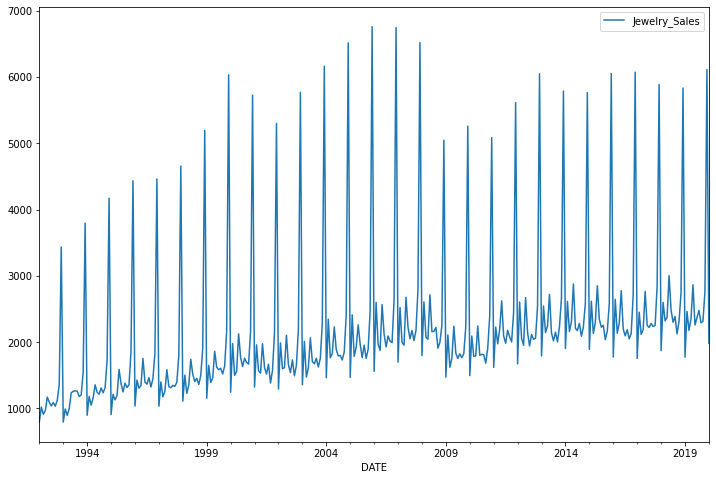

In [9]:
df.plot(figsize=(12,8));

In [10]:
# ETS - Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [11]:
results = seasonal_decompose(df["Jewelry_Sales"])

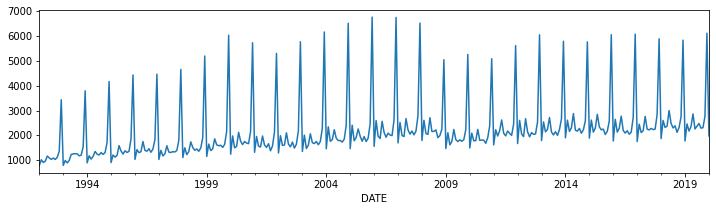

In [12]:
# Observed 
results.observed.plot(figsize=(12,3));

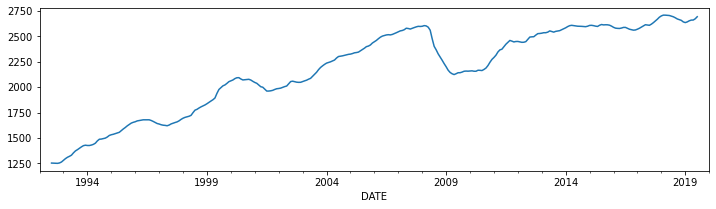

In [13]:
# Trend
results.trend.plot(figsize=(12,3));

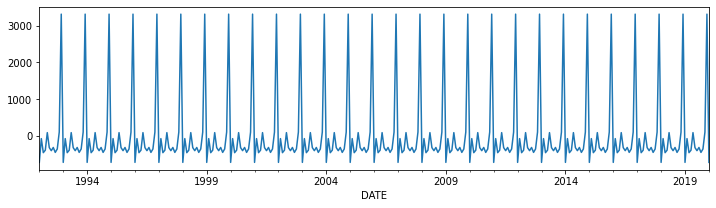

In [14]:
# Seasonal
results.seasonal.plot(figsize=(12,3));

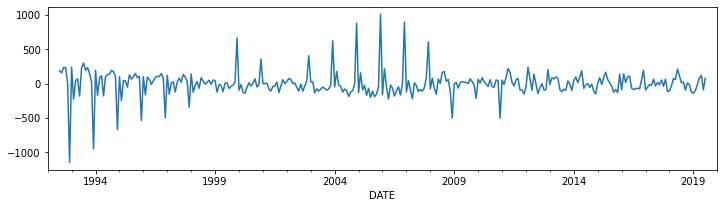

In [15]:
# Error
results.resid.plot(figsize=(12,3));

In [16]:
# Train and test split
len(df)

337

In [17]:
train = df.iloc[:301]
test = df.iloc[301:]

In [18]:
len(test)

36

In [19]:
# Scale data
from sklearn.preprocessing import MinMaxScaler

In [20]:
scaler = MinMaxScaler()

In [21]:
# We only fit to tarin data
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [22]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [23]:
# Time Series Generator
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


In [24]:
# define generator
n_input = 36
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [51]:
# Import model and layers
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [26]:
# define model
model = Sequential()
model.add(LSTM(100, activation="relu",return_sequences=True ,input_shape=(n_input, n_features)))
model.add(LSTM(100, activation="relu",input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 36, 100)           40800     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [28]:
# fit model
model.fit_generator(generator,epochs=20)

Epoch 1/20
265/265 [==============================] - 9s 33ms/step - loss: 0.0396
Epoch 2/20
265/265 [==============================] - 8s 31ms/step - loss: 0.0368
Epoch 3/20
265/265 [==============================] - 8s 31ms/step - loss: 0.0365
Epoch 4/20
265/265 [==============================] - 8s 30ms/step - loss: 0.0343
Epoch 5/20
265/265 [==============================] - 8s 29ms/step - loss: 0.0304
Epoch 6/20
265/265 [==============================] - 8s 31ms/step - loss: 0.0292
Epoch 7/20
265/265 [==============================] - 9s 32ms/step - loss: 0.0289
Epoch 8/20
265/265 [==============================] - 9s 33ms/step - loss: 0.0231
Epoch 9/20
265/265 [==============================] - 8s 32ms/step - loss: 0.0186
Epoch 10/20
265/265 [==============================] - 8s 30ms/step - loss: 0.0099
Epoch 11/20
265/265 [==============================] - 8s 30ms/step - loss: 0.0126
Epoch 12/20
265/265 [==============================] - 8s 31ms/step - loss: 0.0040
Epoch 13/20
2

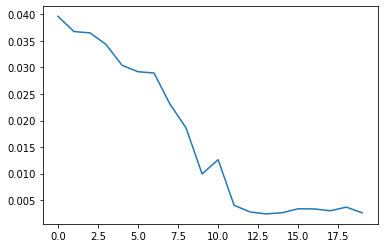

In [29]:
loss_per_epoch = model.history.history["loss"]
plt.plot(range(len(loss_per_epoch)),loss_per_epoch);

In [30]:
# Evaluate on test data
first_eval_batch = scaled_train[-36:]

In [31]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [32]:
# Inverse Transformations and Compare
true_predictions = scaler.inverse_transform(test_predictions)

In [33]:
# Create a new column with prediction values
test["Predictions"] = true_predictions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


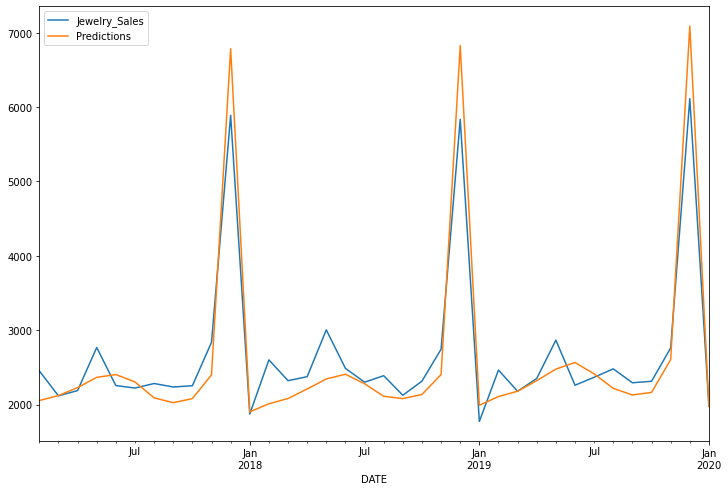

In [41]:
# Plotting
test.plot(figsize=(12,8));

In [42]:
# Let's evaluate models
from sklearn.metrics import mean_squared_error

In [49]:
# Root Mean Squared Error
RMSE = np.sqrt(mean_squared_error(test["Jewelry_Sales"],true_predictions))

In [50]:
RMSE

374.8739003547931